### Implementazione di una rete con architettura **U-Net**

* scaricare il [dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz) e le [annotazioni](https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz) dal repository ufficiale del dataset: https://www.robots.ox.ac.uk/~vgg/data/pets/

In [25]:
# importazione librerie necessarie

import os
import random
from IPython.display import Image, display
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
import numpy as np
import PIL
from PIL import ImageOps

In [26]:
input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160)
num_classes = 3
batch_size = 32

input_img_paths = sorted([
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
])

target_img_paths = sorted([
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
])

print("numero di esempi:", len(input_img_paths))
# --- risultato atteso:
# numero di esempi: 7390

numero di esempi: 7390


In [27]:
# check prime 10 path dei primi 10 esempi:
for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)
    # images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
    # images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
    # images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
    # images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
    # images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
    # images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
    # images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
    # images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
    # images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
    # images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png

images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


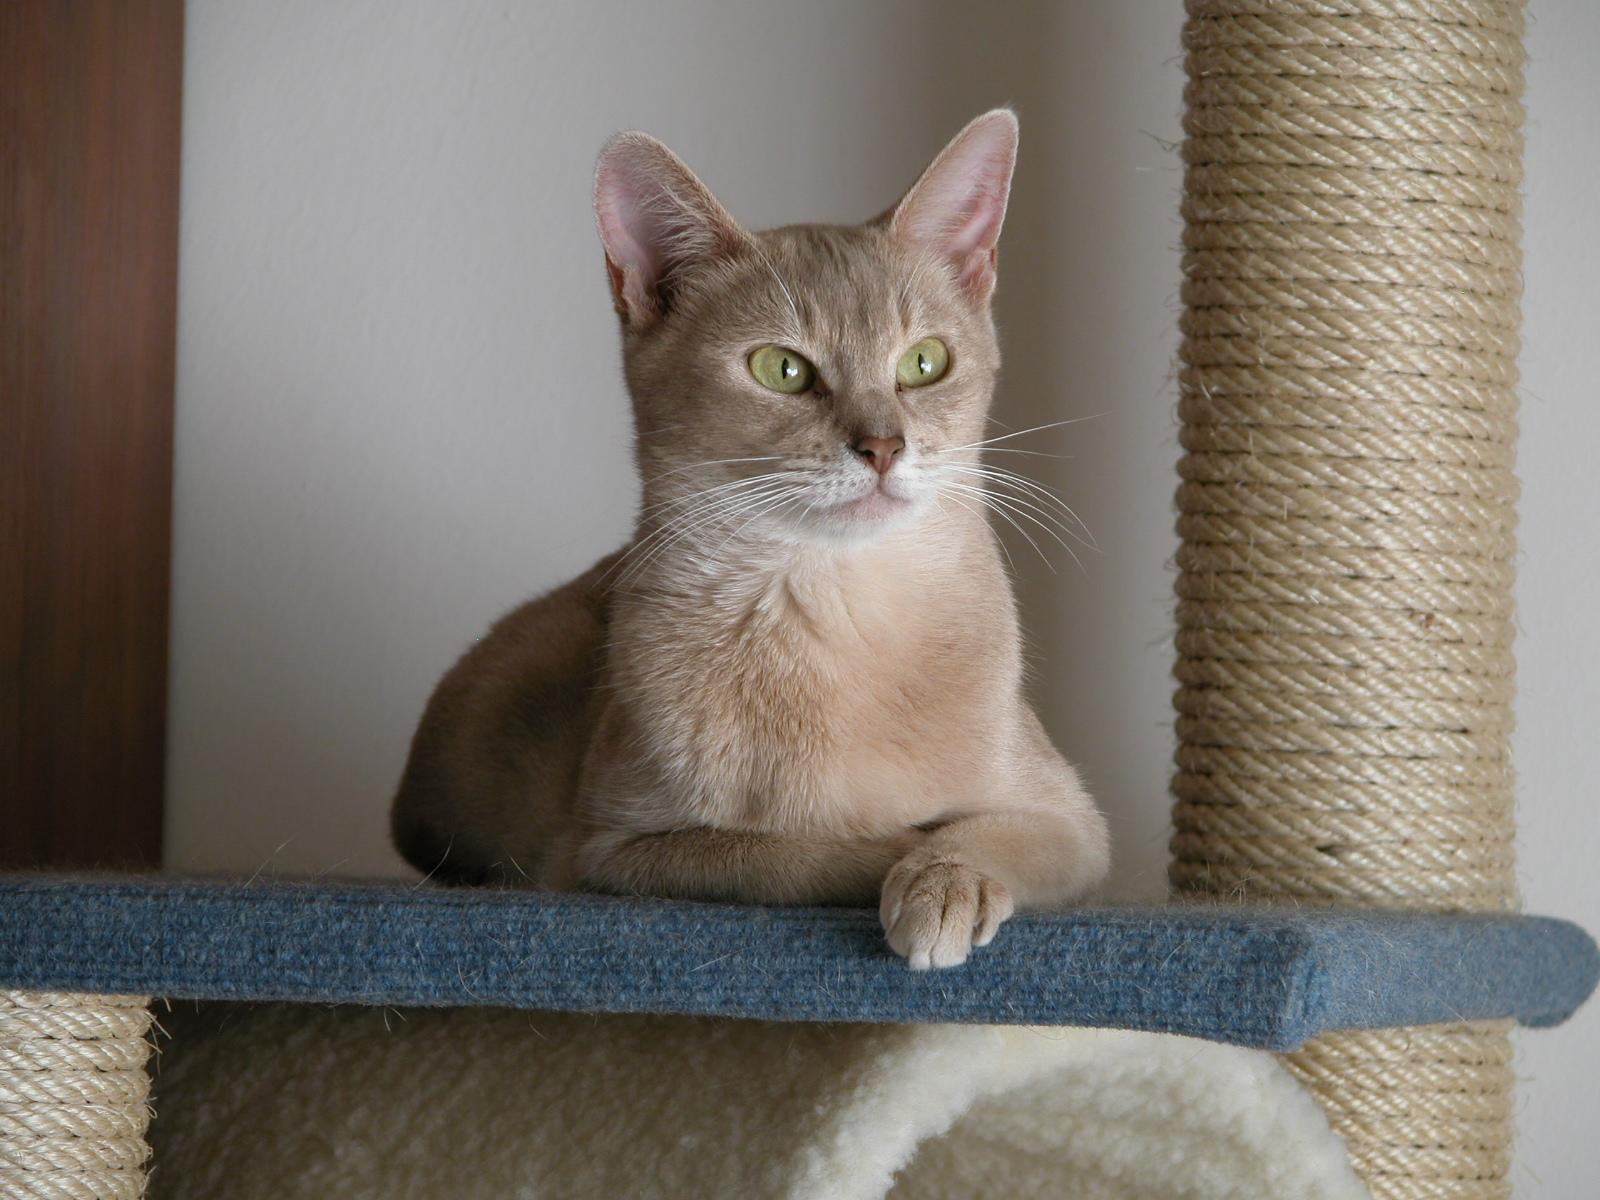

In [28]:
# Visualizzare l'immagine #42

display(Image(filename=input_img_paths[42]))
# --- risultato atteso:
# visualizzazione di una foto

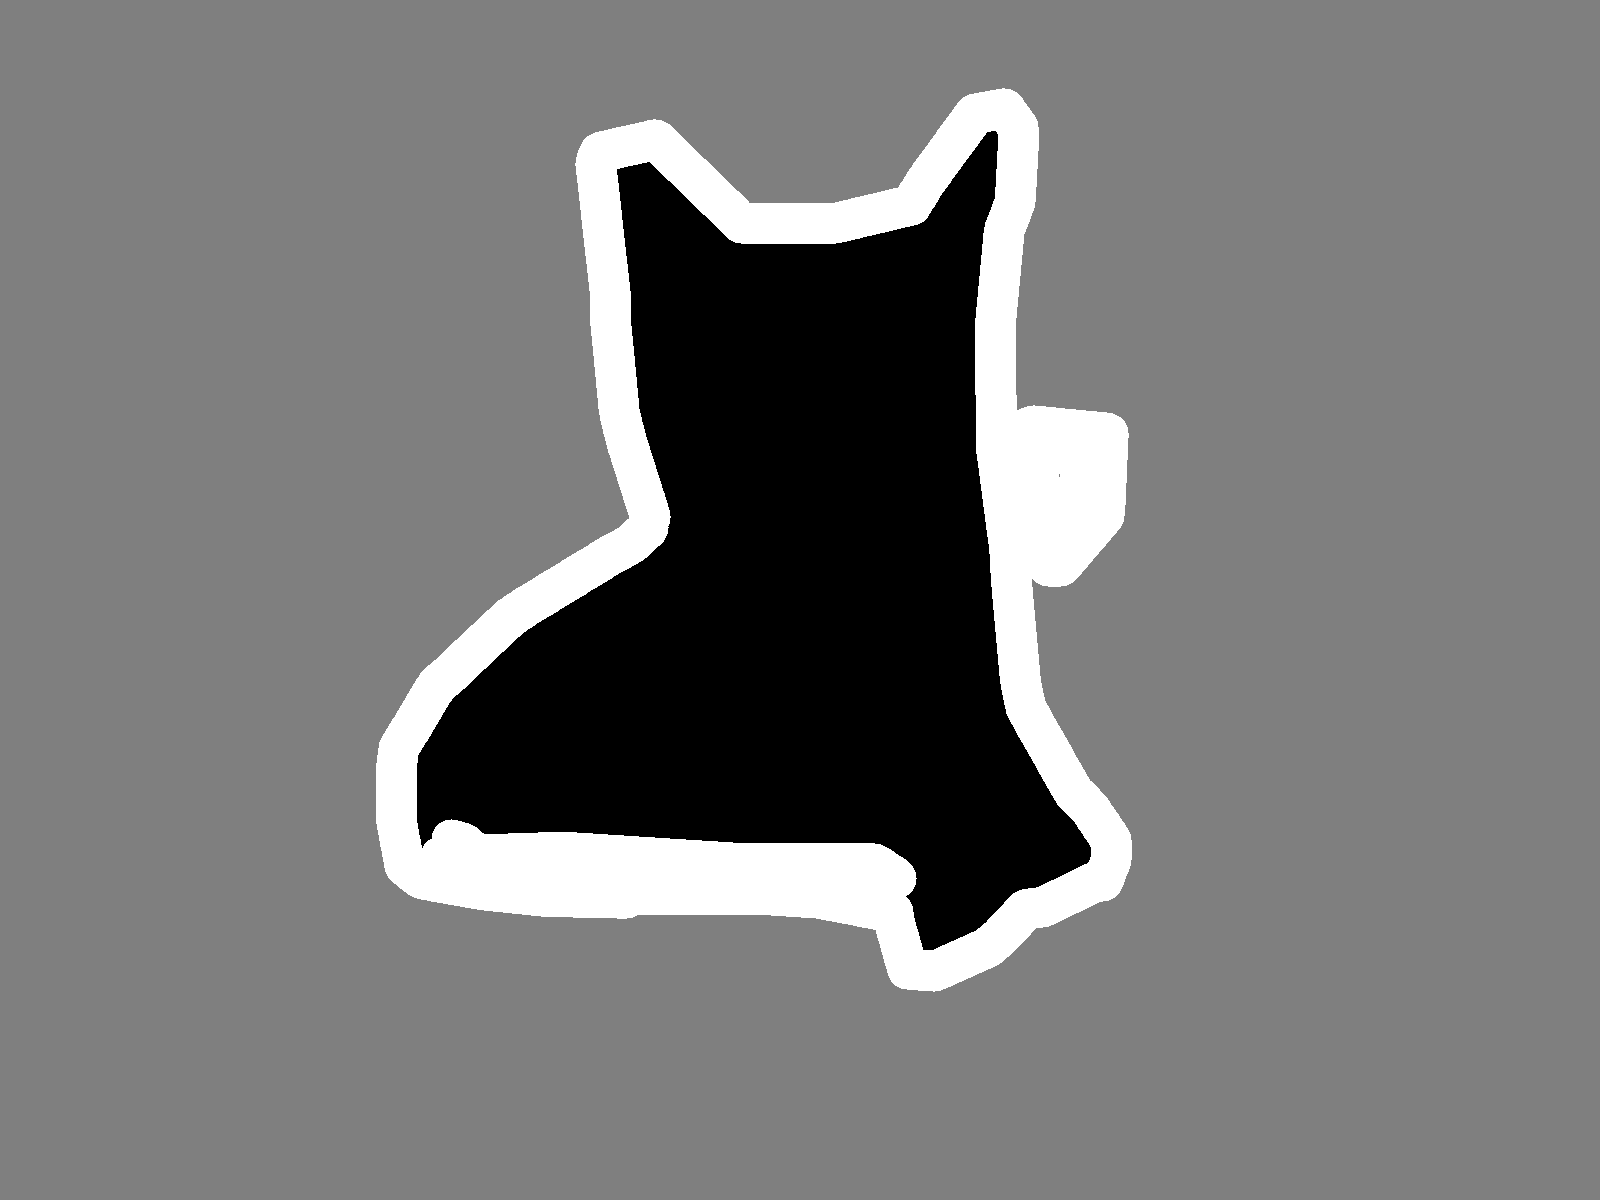

In [29]:
# Visualizzazione dell'immagine raffigurante l'area e il contorno
# del soggetto dell'immagine alla cella precedente, sfruttando il
# metodo autocontrast disponibile in PIL

img = PIL.ImageOps.autocontrast(
    load_img(target_img_paths[42])
)
# --- risultato atteso:
# mappa dei contorni del gatto dell'immagine alla cella precedente
display(img)

### Trimap
Come suggerisce il nome, una trimap di un'immagine I è una partizione contenente
tre insiemi di regioni: F, B e M.
L'insieme **F** contiene informazioni sui pixel in primo piano, l'insieme **B**
contiene informazioni sui pixel di sfondo e **M** è una regione intermedia che
separa F da B.
Si potrebbe pensare a trimap come una maschera che contiene una regione bianca
che definisce F, una regione nera che definisce B e una regione grigia che
definisce M, che è spesso una regione di incertezza.

In [6]:
class OxfordPets(keras.utils.Sequence):
    '''
    Classe utile a scorrere il dataset, estende la classe Sequence
    di Keras (https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence)
    Permette l'esecuzione in parallelo del metodo __getitem__ da parte
    del processo di ottimizzazione
    '''

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        # Restituisce la tupla (input, target) corrispondente
        # al batch #idx
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Siccome le label sono in base 1, sottraiamo 1 per
            # averle con valori 0, 1 o 2
            y[j] -= 1
        return x, y

### SeparableConv2D
E' una variazione della convoluzione tradizionale, proposta per calcolarla più velocemente.
Esegue una convoluzione spaziale in profondità seguita da una convoluzione
puntuale che mescola insieme i canali di output risultanti.
![sep_conv](images/separable_conv_2d.png)
Con meno moltiplicazioni da effettuare, la complessità computazione scende, permettendo alla
rete di addestrarsi più velocemente.

In [7]:
def get_model(img_size, num_classes):
    # aggiungo i 3 canali colori alle dimensioni
    # delle immagini del dataset
    inputs = keras.Input(shape=img_size + (3,))

    # prima parte della rete, contrazione delle informazioni

    # Blocco convolutivo di ingresso
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # sfruttato per connessione residuale

    # I seguenti tre blocchi sono simili eccetto per
    # il numero dei filtri utilizzati
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # connessione residuale
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x

    # Seconda parte della rete, espansione delle informazioni
    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])
        previous_block_activation = x

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model


# Svuota la memoria occupata da eventuali
# precedenti modelli TensorFlow
keras.backend.clear_session()

# Creazione modello
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 80, 80, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 80, 80, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [8]:
# Suddivisione del dataset in addestramento e validazione
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:900]
train_target_img_paths = target_img_paths[:900]
val_input_img_paths = input_img_paths[900:]
val_target_img_paths = target_img_paths[900:]

# Creazione di due Sequence di dati per l'addestramento
# e la validazione del modello
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)

val_gen = OxfordPets(
    batch_size, img_size, val_input_img_paths, val_target_img_paths
)

In [9]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("data/oxford_segmentation.h5", save_best_only=True)
]

epochs = 50

# Addestramento
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/50
28/28 [==============================] - 20s 503ms/step - loss: 3.1370 - val_loss: 2.9022


c:\fh_formazioneinterna\venv_rl\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 2/50
28/28 [==============================] - 13s 475ms/step - loss: 0.9783 - val_loss: 2.7544
Epoch 3/50
28/28 [==============================] - 13s 475ms/step - loss: 0.9279 - val_loss: 1.6158
Epoch 4/50
28/28 [==============================] - 13s 470ms/step - loss: 0.8435 - val_loss: 1.6800
Epoch 5/50
28/28 [==============================] - 13s 475ms/step - loss: 0.8508 - val_loss: 1.6177
Epoch 6/50
28/28 [==============================] - 13s 483ms/step - loss: 0.8032 - val_loss: 1.1858
Epoch 7/50
28/28 [==============================] - 14s 491ms/step - loss: 0.8032 - val_loss: 1.8632
Epoch 8/50
28/28 [==============================] - 14s 506ms/step - loss: 0.7893 - val_loss: 1.4090
Epoch 9/50
28/28 [==============================] - 14s 518ms/step - loss: 0.7782 - val_loss: 1.2719
Epoch 10/50
28/28 [==============================] - 15s 551ms/step - loss: 0.7598 - val_loss: 1.4467
Epoch 11/50
28/28 [==============================] - 15s 541ms/step - loss: 0.7370 - val_l

2214


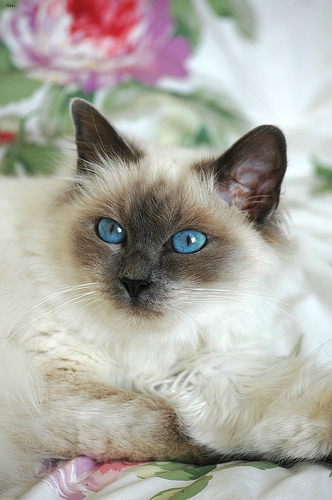

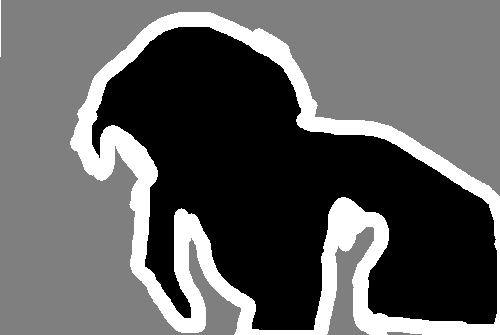

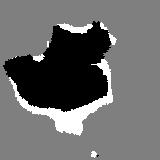

In [10]:
# Generazione delle predizioni
print(len(val_input_img_paths))
val_preds = model.predict(val_gen)

def display_mask(i):
    # visualizzazione di una delle predizioni
    mask = np.argmax(val_preds[i], axis=-1) # val_preds ha 3 canali, così in mask
                                            # viene creata un'immagine senza canali
                                            # in quanto argmax appiattisce l'ultima
                                            # dimensione
    mask = np.expand_dims(mask, axis=-1) # ritorno della shape di mask alle
                                         # dimensioni consone di una immagine:
                                         # w, h, c
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)

# Visualizzazione predizioni modello
# su un paricolare esempio
idx = 42

# visualizzazione immagine originale
display(Image(filename=val_input_img_paths[idx]))

# visualizzazione sagoma reale
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[idx]))
display(img)

# visualizzazione sagoma predetta
display_mask(idx)